# Building a Neural Network from scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict

## Import Data

In [29]:
mnist_test = pd.read_csv('MNIST_CSV/mnist_test.csv')
mnist_train = pd.read_csv('MNIST_CSV/mnist_train.csv')
mnist_test = np.array(mnist_test).T
mnist_train = np.array(mnist_train).T

## Test plot for a number

(-0.5, 27.5, 27.5, -0.5)

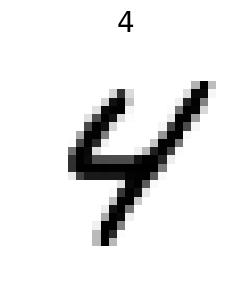

In [321]:
fig, ax = plt.subplots(figsize=(3, 3))
randint = np.random.randint(0, mnist_train.shape[1])
ax.imshow(np.reshape(mnist_train[1:, randint], (28, 28)), cmap='Greys')
ax.set_title(f"{mnist_train[0, randint]}", fontsize=20)
ax.axis('off') 

### Change single label into array of 0s and 1s, (one hot)

In [32]:
def one_hot(label):
    Y = np.zeros(10)
    Y[label] = 1
    return Y

## Coding one Neuron

In [33]:
class Neuron:
    def __init__(self, weight, biases, input):
        self.weight = weight
        self.biases = biases
        self.input = input
        self.output = 0 
    
    def forward(self) -> float:
        self.output = np.dot(self.input, self.weight) + self.biases
        return self.output

In [34]:
w = np.random.uniform(0, 5, 5)
b = np.random.uniform(0, 5, 5)
X_data = np.random.uniform(0, 100, 5)

neuron = Neuron(weight=w, biases=b, input=X_data)
output = neuron.forward()

print(output)

[333.62341491 330.99998991 330.24445654 331.34051918 330.611839  ]


## Whole Network of hidden layers and neurons

In [406]:
def Linear(x, weights, bias):
    """Linear hidden layer"""
    return weights.dot(x) + bias

def ReLU(inputs) -> np.ndarray:
    """Activation function"""
    return np.maximum(0, inputs)

def softMax(inputs: np.ndarray) -> np.ndarray:
    exps = np.exp(inputs - inputs.max())
    return exps / np.sum(exps)

def initialise_weights(num_HL, HL_structure, num_inputs, num_outputs) -> (np.ndarray, np.ndarray):
    params = {"W0": np.random.normal(0, 2/num_inputs, size=(HL_structure[0], num_inputs))}
    for i in range(num_HL-1):
        params[f"W{i+1}"] = np.random.normal(0, 2/HL_structure[i], size=(HL_structure[i+1], HL_structure[i], ))
    params[f"W{num_HL}"] = np.random.normal(0, 2/HL_structure[-1], size=(num_outputs, HL_structure[-1]))
    biases = np.zeros(num_HL+2)
    return params, biases

class NeuralNetwork:
    def __init__(self, num_inputs, hidden_layer_structure, num_outputs, lr=0.1):
        self.num_inputs = num_inputs
        self.num_hidden_layers = len(hidden_layer_structure)
        self.hidden_layer_structure = hidden_layer_structure
        self.num_outputs = num_outputs
        self.lr = lr
        
        # Randomly initialise weights and biases
        self.weights, self.biases = initialise_weights(num_HL=self.num_hidden_layers,
                                              HL_structure=self.hidden_layer_structure,
                                              num_inputs=self.num_inputs,
                                              num_outputs=self.num_outputs)
        # Information I may want
        self.num_nodes = self.num_hidden_layers + sum(hidden_layer_structure)

    def forward(self, x):
        Zs, As = {}, {}
        for i, weight_matrix in enumerate(self.weights.values()):
            if i == 0:
                Zs[f"Z{i}"] = Linear(x, weight_matrix, self.biases[i])
                As[f"A{i}"] = ReLU(Zs[f"Z{i}"])
            else:
                Zs[f"Z{i}"] = Linear(As[f"A{i-1}"], weight_matrix, self.biases[i])
                As[f"A{i}"] = ReLU(Zs[f"Z{i}"])
        return Zs, As
    
    def update_weights(self, grad_w, grad_b):
        for i in range(len(self.weights)):
            self.weights[f"W{i}"] -= self.lr * grad_w[f"W{i}"]

In [444]:
def cross_entropy(outputs, targets):
    """Classification Loss Function"""
    return - np.sum(softMax(targets) * np.log(outputs))

def deriv_ReLU(x):
    ret = np.zeros_like(x)
    ret[x >= 0] = 1
    return ret
    # return x > 0

In [445]:
class Criterion:
    def __init__(self, NN):
        self.NN = NN
        self.params = NN.weights
        
    def backward(self, Zs, As, INPUT, true_label):
        one_hot_true_label = one_hot(true_label)

        m = len(INPUT) # Need to fix

        dz = softMax(As[f"A{len(self.params)-1}"]) - one_hot_true_label
        dw = (1/m) * dz[:, None].dot(As[f"A{len(self.params)-2}"][:, None].T)
        grad_w = {f"W{len(self.params)-1}": dw}

        for i in range(len(self.params)-2, 0, -1):
            m = len(Zs[f"Z{i+1}"])
            dz = self.params[f"W{i+1}"].T.dot(dz * deriv_ReLU(Zs[f"Z{i+1}"]))
            dw = (1/m) * dz[:, None].dot(As[f"A{i-1}"][:, None].T)
            grad_w[f"W{i}"] = dw
        dz = self.params[f"W{i}"].T.dot(dz * deriv_ReLU(Zs[f"Z{i}"]))
        dw = (1/m) * dz[:, None].dot(INPUT[:, None].T)
        grad_w[f"W{i-1}"] = dw
        # [print(key, value.shape) for key, value in grad_w.items()]
        return grad_w, {}
    


In [446]:
rand_num = mnist_train[1:, randint]
true_label = mnist_train[0, randint]

NN = NeuralNetwork(num_inputs=784,
                   hidden_layer_structure=[128, 64],
                   num_outputs=10)
loss = Criterion(NN)
# Zs, As = NN.forward(rand_num)
# # [print(key, value.shape) for key, value in Zs.items()]
# # [print(key, value.shape) for key, value in As.items()]
# # [print(key, value.shape) for key, value in NN.weights.items()]
# grad_w, grad_b = loss.backward(Zs, As, rand_num, true_label)
# NN.update_weights(grad_w=grad_w,grad_b=grad_b)
# print(grad_w)
# print(NN.weights["W0"] - grad_w["W0"].T)

In [447]:
num_epochs = 1

for epoch in range(num_epochs):
    for i, img in enumerate(mnist_train.T):
        label = img[0]
        data = img[1:]
        Zs, As = NN.forward(data)
        grad_w, grad_b = loss.backward(Zs, As, data, label)
        NN.update_weights(grad_w=grad_w, grad_b=grad_b)
        
        if i % 1000 == 0:
            error = np.round(sum(softMax(As[f"A{len(NN.weights)-1}"]) - softMax(label)), 2)
            print(f"Training... | Error: {error} | Epoch {epoch + 1}/{num_epochs} | Image {i} / {mnist_train.shape[1]}", end="\r")

/var/folders/qx/bq5p9s1j74x1p25jhkg_w_rh0000gn/T/ipykernel_52157/4266513174.py:10: RuntimeWarning: invalid value encountered in subtract
  exps = np.exp(inputs - inputs.max())


KeyboardInterrupt: 

In [415]:
for i, img in enumerate(mnist_test.T):
    label = img[0]
    data = img[1:]
    Zs, As = NN.forward(data)
    guess = softMax(As[f"A{len(NN.weights)-1}"])
    
    
    print(guess)
    print(f"{one_hot(label)}\n")

[nan nan nan nan nan nan nan nan nan nan]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

[nan nan nan nan nan nan nan nan nan nan]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

[nan nan nan nan nan nan nan nan nan nan]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

[nan nan nan nan nan nan nan nan nan nan]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

[nan nan nan nan nan nan nan nan nan nan]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

[nan nan nan nan nan nan nan nan nan nan]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

[nan nan nan nan nan nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

[nan nan nan nan nan nan nan nan nan nan]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

[nan nan nan nan nan nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

[nan nan nan nan nan nan nan nan nan nan]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

[nan nan nan nan nan nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

[nan nan nan nan nan nan nan nan nan nan]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

[nan nan nan nan nan nan nan nan nan nan]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

[nan nan nan nan nan nan 